## BE
- [Kaggle](https://www.kaggle.com/datasets/walterconway/covid-flu-cold-symptoms/data)

1. Data Preprocessing

In [1]:
# Install the necessary library
# %pip install pandas numpy matplotlib scikit-learn joblib
# Import all the necessary libraries for data cleaning and machine learning algorithms (decision tree)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import joblib as joblib

Get rid of unnecessary rows and columns

In [2]:
df = pd.read_csv('large_data.csv')
print(f"Row count initially: {df['TYPE'].count()}")
# Drop rows that are not type of FLU (eg. COVID-19, Cold)
df = df[df['TYPE'] == 'FLU']
# Reset the index of DataFrame
df = df.reset_index(drop=True)
# Display the data count after dropping rows
print(f"Row count afterwards: {df['TYPE'].count()}")

Row count initially: 44453
Row count afterwards: 25000


trimming whitespaces if theres any

In [3]:
# Trim the whitespaces in the column
df.columns = df.columns.str.strip()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   COUGH                 25000 non-null  int64 
 1   MUSCLE_ACHES          25000 non-null  int64 
 2   TIREDNESS             25000 non-null  int64 
 3   SORE_THROAT           25000 non-null  int64 
 4   RUNNY_NOSE            25000 non-null  int64 
 5   STUFFY_NOSE           25000 non-null  int64 
 6   FEVER                 25000 non-null  int64 
 7   NAUSEA                25000 non-null  int64 
 8   VOMITING              25000 non-null  int64 
 9   DIARRHEA              25000 non-null  int64 
 10  SHORTNESS_OF_BREATH   25000 non-null  int64 
 11  DIFFICULTY_BREATHING  25000 non-null  int64 
 12  LOSS_OF_TASTE         25000 non-null  int64 
 13  LOSS_OF_SMELL         25000 non-null  int64 
 14  ITCHY_NOSE            25000 non-null  int64 
 15  ITCHY_EYES            25000 non-null

checking missing values

In [ ]:
df.isna().sum()

counting & cleaning feature values

In [4]:
# Drop columns that are only zeros
for col in df.columns:
	# If the count of the most frequent value is equal to the length of the dataframe (25k)
	# then drop the column
	if df[col].value_counts()[0] == len(df):
		df.drop(col, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   COUGH                 25000 non-null  int64
 1   MUSCLE_ACHES          25000 non-null  int64
 2   TIREDNESS             25000 non-null  int64
 3   SORE_THROAT           25000 non-null  int64
 4   RUNNY_NOSE            25000 non-null  int64
 5   STUFFY_NOSE           25000 non-null  int64
 6   FEVER                 25000 non-null  int64
 7   NAUSEA                25000 non-null  int64
 8   VOMITING              25000 non-null  int64
 9   DIARRHEA              25000 non-null  int64
 10  SHORTNESS_OF_BREATH   25000 non-null  int64
 11  DIFFICULTY_BREATHING  25000 non-null  int64
 12  LOSS_OF_TASTE         25000 non-null  int64
 13  LOSS_OF_SMELL         25000 non-null  int64
 14  SNEEZING              25000 non-null  int64
dtypes: int64(15)
memory usage: 2.9 MB


duplicates

In [ ]:
df.duplicated().sum()
df.duplicated().value_counts()
# df.info()


create new column to fill in severity data

In [5]:
def classify_symptoms(row) -> int:
    # Apply your classification rules to the row
    if row['SHORTNESS_OF_BREATH'] == 1 or row['DIFFICULTY_BREATHING'] == 1:
        return 1
    else:
        return 0

# Create a new column 'SEVERITY' in the DataFrame 'df' using the 'apply()' method
df['SEVERITY'] = df.apply(classify_symptoms, axis=1)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   COUGH                 25000 non-null  int64
 1   MUSCLE_ACHES          25000 non-null  int64
 2   TIREDNESS             25000 non-null  int64
 3   SORE_THROAT           25000 non-null  int64
 4   RUNNY_NOSE            25000 non-null  int64
 5   STUFFY_NOSE           25000 non-null  int64
 6   FEVER                 25000 non-null  int64
 7   NAUSEA                25000 non-null  int64
 8   VOMITING              25000 non-null  int64
 9   DIARRHEA              25000 non-null  int64
 10  SHORTNESS_OF_BREATH   25000 non-null  int64
 11  DIFFICULTY_BREATHING  25000 non-null  int64
 12  LOSS_OF_TASTE         25000 non-null  int64
 13  LOSS_OF_SMELL         25000 non-null  int64
 14  SNEEZING              25000 non-null  int64
 15  SEVERITY              25000 non-null  int64
dtypes: i

In [ ]:
df['SEVERITY'].value_counts()
df.head()

save dataframe to csv

In [ ]:
# save dataframe to csv file
df.to_csv('cleaned_data.csv', index=False)

correlation

In [ ]:
# Ignore TYPE column
df_corr = df.corr()
df_corr
df.info()

Splitting and training the data (Decision Tree)

In [ ]:
symptoms = [i for i in df.columns if i != 'SEVERITY']
severity = ['SEVERITY']
# Split the data into training and testing sets
# 20% of the data will be used for testing
X_train, X_test, y_train, y_test = train_test_split(df[symptoms], df[severity], test_size=0.2, random_state=42)

# Create a Decision Tree Classifier object
dt = DecisionTreeClassifier()

# Train the model on the training set
dt.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = dt.predict(X_test)

# create a function to evaluate the performance of the model
def evaluate_model(y_true, y_pred):
	# Calculate and print confusion matrix plot
	disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred))
	disp.plot()
	plt.show()
	# Calculate and print the classification report
	report = classification_report(y_true, y_pred)
	print(report)
evaluate_model(y_test, y_pred)

joblib.dump(dt, 'decision_tree_model.joblib')

Consulted with SV, need to do more data preprocessing due to accuracy issues

In [28]:
df_without_target = df.drop('SEVERITY', axis=1)
df_without_target.head()

,COUGH,MUSCLE_ACHES,TIREDNESS,SORE_THROAT,RUNNY_NOSE,STUFFY_NOSE,FEVER,NAUSEA,VOMITING,DIARRHEA,SHORTNESS_OF_BREATH,DIFFICULTY_BREATHING,LOSS_OF_TASTE,LOSS_OF_SMELL,SNEEZING
0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0
1,0,1,1,1,0,0,1,0,0,0,1,0,1,0,0
2,0,0,0,1,1,1,0,0,0,0,1,1,1,0,0
3,1,0,1,0,0,1,0,1,1,0,0,0,1,0,1
4,1,1,1,1,1,0,1,0,0,1,1,1,0,0,0


Do a chi square test to see if there is a correlation between the symptoms and the severity

Box Plotting
- used to find outliers in the form of dot over the bar plot

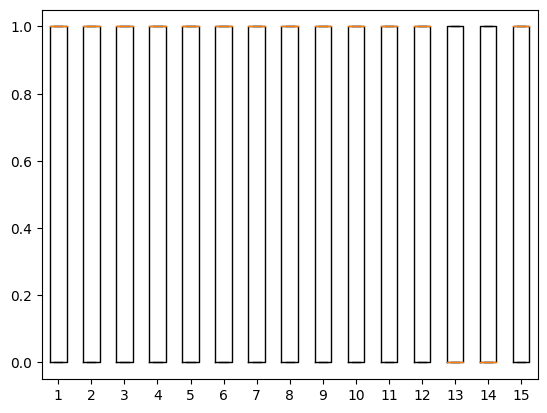

In [29]:
import matplotlib.pyplot as plt

plt.boxplot(df_without_target)
plt.show()

Z-Score

In [30]:
from scipy import stats

z_scores = stats.zscore(df_without_target)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_without_target = df_without_target[filtered_entries]


Removing outliers

In [26]:
# Remove outliers from the dataset
# Assuming df is your DataFrame and 'column' is the column from which you want to remove outliers
# Use interquartile range to remove outliers
for col in df_without_target.columns:
	Q1 = df_without_target[col].quantile(0.25)
	Q3 = df_without_target[col].quantile(0.75)
	IQR = Q3 - Q1

	lower_bound = Q1 - 1.5 * IQR
	upper_bound = Q3 + 1.5 * IQR

	df_without_outliers = df_without_target[(df_without_target[col] >= lower_bound) & (df_without_target[col] <= upper_bound)]
df_without_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   COUGH                 25000 non-null  int64
 1   MUSCLE_ACHES          25000 non-null  int64
 2   TIREDNESS             25000 non-null  int64
 3   SORE_THROAT           25000 non-null  int64
 4   RUNNY_NOSE            25000 non-null  int64
 5   STUFFY_NOSE           25000 non-null  int64
 6   FEVER                 25000 non-null  int64
 7   NAUSEA                25000 non-null  int64
 8   VOMITING              25000 non-null  int64
 9   DIARRHEA              25000 non-null  int64
 10  SHORTNESS_OF_BREATH   25000 non-null  int64
 11  DIFFICULTY_BREATHING  25000 non-null  int64
 12  LOSS_OF_TASTE         25000 non-null  int64
 13  LOSS_OF_SMELL         25000 non-null  int64
 14  SNEEZING              25000 non-null  int64
dtypes: int64(15)
memory usage: 2.9 MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   SHORTNESS_OF_BREATH   25000 non-null  int64
 1   DIFFICULTY_BREATHING  25000 non-null  int64
 2   LOSS_OF_SMELL         25000 non-null  int64
 3   LOSS_OF_TASTE         25000 non-null  int64
 4   MUSCLE_ACHES          25000 non-null  int64
dtypes: int64(5)
memory usage: 976.7 KB


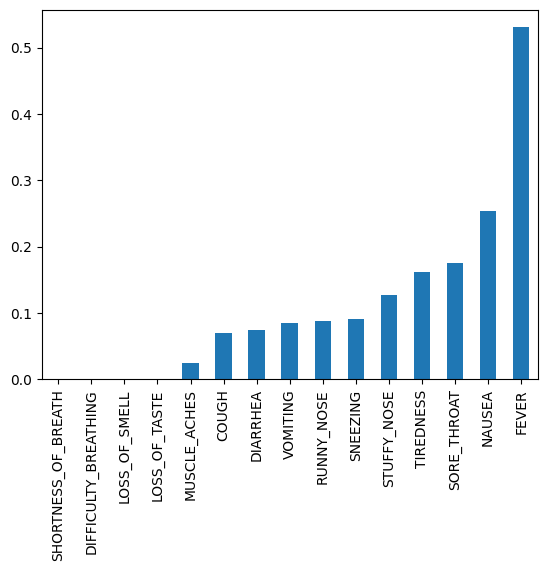

In [20]:

# Do a chi square test to find the most important features based on their p-values
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Create a SelectKBest object to select features with top 10 highest chi square values
best_features = SelectKBest(score_func=chi2, k=10)
best_features.fit(df_without_target, df['SEVERITY'])

chi_scores = chi2(df_without_target, df['SEVERITY'])
p_values = pd.Series(chi_scores[1], index=df_without_target.columns)
p_values.sort_values(ascending=True, inplace=True)
p_values.plot.bar()
pval = 0.05
df_without_target = df_without_target[p_values[p_values < pval].index]
df_without_target.info()

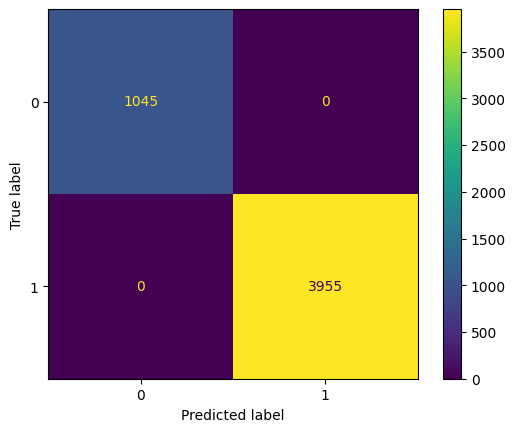

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1045
           1       1.00      1.00      1.00      3955

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000

1.0
Accuracy: 1.00 (+/- 0.00)


In [22]:
# Split the data into training and testing sets
# 20% of the data will be used for testing
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(df_without_target, df['SEVERITY'], test_size=0.2, random_state=42)

dt = DecisionTreeClassifier()

def evaluate_model(y_true, y_pred):
	# Calculate and print confusion matrix plot
	disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred))
	disp.plot()
	plt.show()
	# Calculate and print the classification report
	report = classification_report(y_true, y_pred)
	print(report)
	print(accuracy_score(y_test, y_pred))

dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
evaluate_model(y_test, y_pred)
# Measure the accuracy of the model

from sklearn.model_selection import cross_val_score

# Assuming clf is your decision tree model
scores = cross_val_score(dt, df_without_target, df['SEVERITY'], cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Training the data using Random Forest Classifier

In [ ]:
# Train the data using random classifier from scikit
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train.values.ravel())
y_pred = rf.predict(X_test)
evaluate_model(y_test, y_pred)
print(f"Accuracy: {rf.score(X_test, y_test)}")

Training the data using SVM

In [ ]:
# Train the data using SVM from scikit
from sklearn.svm import SVC
svm = SVC(random_state=42)
svm.fit(X_train, y_train.values.ravel())
y_pred = svm.predict(X_test)
evaluate_model(y_test, y_pred)
print(f"Accuracy: {svm.score(X_test, y_test)}")

In [ ]:
# Prepare your input data
sym = [1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0]
my_input = pd.DataFrame([sym], columns=symptoms)
print(my_input)

# Load the trained model
model = joblib.load('decision_tree_model.pkl')

# Make predictions on the input data
y_pred = model.predict(my_input)

# # Print the predicted label
from sklearn import metrics
print("Predicted label:", y_pred[0])

Cross-fold validation

In [ ]:
from sklearn.model_selection import cross_val_score

cv_amt = 10
# Perform 20-fold cross-validation on decision tree (dt)
dt_scores = cross_val_score(dt, df[symptoms], df[severity], cv=cv_amt, n_jobs=-1)
rf_scores = cross_val_score(rf, df[symptoms], df[severity].values.ravel(), cv=cv_amt, n_jobs=-1)
svm_scores = cross_val_score(svm, df[symptoms], df[severity].values.ravel(), cv=cv_amt, n_jobs=-1)

# Print the average score and standard deviation
scores = pd.DataFrame({'ML Techniques' : ['Decision Tree', 'Random Forest', 'SVM'], 'Score' : [dt_scores.mean(), rf_scores.mean(), svm_scores.mean()], 'Standard Deviation' : [dt_scores.std(), rf_scores.std(), svm_scores.std()]})
print(scores.sort_values(by='Score', ascending=False))

Export the decision tree to an image

In [ ]:
from sklearn.tree import export_graphviz
import pydotplus
from io import StringIO
dt = joblib.load('decision_tree_model.pkl')

# Export the decision tree to a DOT file
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, 
    feature_names=symptoms,  
    class_names=['0', '1'], 
    special_characters=True, 
    rounded=True, 
    proportion=False,
    filled=True)

# export the decision tree to a png file
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('decision_tree.png')
print(df['SEVERITY'].value_counts())